# test UMAP scalability

In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
warnings.simplefilter('ignore', FitFailedWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', UserWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time
import warnings
import joblib
from pathlib import Path
from time import time
from tqdm import tqdm
import copy
import matplotlib as mpl
import napari
import colorcet as cc
import composition_stats as cs
from sklearn.impute import KNNImputer
from lifelines import KaplanMeierFitter, CoxPHFitter
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from importlib import reload

from tysserand import tysserand as ty
from mosna import mosna

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'
mpl.rcParams["savefig.facecolor"] = 'white'

print('loading data')
data_dir = Path("../data/raw/IMC_Breast_cancer_Danenberg_2022")
objects_path = data_dir / "SingleCells.csv"

if objects_path.with_suffix('.parquet').exists():
    obj = pd.read_parquet(objects_path.with_suffix('.parquet'))
else:
    obj = pd.read_csv(objects_path)
    # for latter use
    obj.to_parquet(objects_path.with_suffix('.parquet'))

obj.rename(columns={'Location_Center_X': 'x', 'Location_Center_Y': 'y'}, inplace=True)
sample_col = 'ImageNumber'  # != from `sample_cols`
patient_col = 'metabric_id'
pheno_col = 'cellPhenotype'
sample_cols = [sample_col, patient_col, pheno_col, 'ObjectNumber']
# this file contains 'c-Caspase3c-PARP' instead of 'c-Caspase3c' as in the dataframe
# all_epitopes = pd.read_csv(data_dir / 'markerStackOrder.csv').iloc[:, 1].values
# so instead we directly do:
all_epitopes = obj.columns[11:50].values
# remove Histone H3 and DNA markers
marker_cols = list(all_epitopes[1:-2])
pos_cols = ['x', 'y']
cell_type_cols = [
    'is_epithelial',
    'is_tumour',
    'is_normal',
    'is_dcis',
    'is_interface',
    'is_perivascular',
    'is_hotAggregate',
    ]
nb_phenotypes = obj[pheno_col].unique().size
all_cols = sample_cols + marker_cols + pos_cols + cell_type_cols + [pheno_col]
# columns we want to include in network data
net_cols = pos_cols + [pheno_col] + cell_type_cols + marker_cols

print(f'nb phenotypes: {nb_phenotypes}')
print(f'nb used markers: {len(marker_cols)}')

# Show number of cells per sample
sample_sizes = obj[['ImageNumber', 'ObjectNumber']].groupby(['ImageNumber']).count()

# # aggregate unique pairs of patients and image IDs
# sample_patient_counts = obj[sample_cols].groupby([sample_col, patient_col]).count()
# print(sample_patient_counts)

# # count occurrences of patient IDs in patient / image pairs
# occ = sample_patient_counts.index.get_level_values(1).value_counts()
# print(occ)

# n_patient_multiple = np.sum(occ.values != 1)
# print(f'There are {n_patient_multiple} patients with multiple samples')

# sample_patient_mapper = dict(sample_patient_counts.index.values)

# ------ Survival data ------

survival_path = data_dir / "IMCClinical.csv"
surv = pd.read_csv(survival_path, index_col=0)

net_size_threshold = 150

select = sample_sizes['ObjectNumber'] >= net_size_threshold
print(f"there are {select.sum()} samples with > {net_size_threshold} cells, discarding {len(select) - select.sum()} samples")
sample_sizes = sample_sizes.loc[select, :]
uniq_samples = sample_sizes.index.values

print(f"filtering small samples, full dataframe dropping from {len(obj)} cells to", end=' ')
obj = obj.query("ImageNumber in @uniq_samples")
print(f'{len(obj)} cells')

print(f"survival data dropping from {len(surv)} patients to", end=' ')
uniq_patients = obj['metabric_id'].unique()
surv = surv.query("metabric_id in @uniq_patients")
print(f'{len(surv)} patients')

# make common color mapper
cycle_cmap = False

nodes_labels = obj[pheno_col]
uniq = pd.Series(nodes_labels).value_counts().index

if nodes_labels is not None:
    nb_clust = nodes_labels.max()
    uniq = pd.Series(nodes_labels).value_counts().index

    # choose colormap
    clusters_cmap = mosna.make_cluster_cmap(uniq)
    # make color mapper
    # series to sort by decreasing order
    n_colors = len(clusters_cmap)
    celltypes_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}


# ------ All samples network reconstruction ------

processed_dir = Path('../data/processed/IMC_breast_cancer')
dir_fig_save = processed_dir / 'figures'

trim_dist = 200 # or 'percentile_size'
min_neighbors = 3 # number of nearest nodes to connect for each unconneted node

reconst_dir = processed_dir / f"samples_networks_xy_min_size-{net_size_threshold}_solitary-{min_neighbors}"
save_dir = reconst_dir / "networks_images_common_cmap_saturated_first"
save_dir.mkdir(parents=True, exist_ok=True)
edges_dir = reconst_dir
nodes_dir = reconst_dir

n_uniq_patients = len(uniq_patients)
n_uniq_samples = len(uniq_samples)

# ------ Response groups characteristics and survival analysis ------

# we add attributes to nodes to color network figures
nodes_all = obj[pos_cols + [pheno_col]].copy()
nodes_all = nodes_all.join(pd.get_dummies(obj[pheno_col]))
uniq_phenotypes = nodes_all[pheno_col].unique()  # 'attribute_uniq' in other notebooks

# here we don't use `sample_col` but `patient_col` in the group / unstack procedure to aggregate 
# statistics per patient and condition rather than per sample.

count_types = obj[[patient_col, pheno_col, sample_col]].groupby([patient_col, pheno_col]).count().unstack()
count_types.columns = count_types.columns.droplevel()
count_types = count_types.fillna(value=0).astype(int)
# count_types.index.name = 'sample'
count_types.to_csv(save_dir / 'count_types_per_patient.csv')

total_count_types = count_types.sum().sort_values(ascending=False)

prop_types = count_types.div(count_types.sum(axis=1), axis=0)

surv_orig = surv.copy()
surv = surv.loc[~surv['isValidation'], :]
surv.drop(columns=['isValidation'], inplace=True)

# replace some values with numbers for fitting
mapper_str = {
    'pos': 1,
    'neg': 0,
    np.nan: np.nan,
}
surv.loc[:, 'ERStatus'] = surv['ERStatus'].map(mapper_str)

mapper_bool = {
    True: 1,
    False: 0,
    np.nan: np.nan,
}
surv.loc[:, 'ERBB2_pos'] = surv['ERBB2_pos'].map(mapper_bool)

duration_col = 'yearsToStatus'
event_col = 'DeathBreast'
covariates = ['ERStatus'] #, 'ERBB2_pos'] # else []
strata = 'ERStatus'
drop_last_column = True   # because we use proportions last column is fully determined
drop_nan = True
if drop_last_column:
    df_surv = prop_types.iloc[:, :-1].join(surv[[duration_col, event_col] + covariates], how='inner')
else:
    df_surv = prop_types.join(surv[[duration_col, event_col] + covariates], how='inner')
if drop_nan:
    n_obs_orig = len(df_surv)
    df_surv.dropna(axis=0, inplace=True)
    n_obs = len(df_surv)
    if n_obs != n_obs_orig:
        print(f'discarded {n_obs_orig - n_obs} / {n_obs_orig} observations with NaN')

loading data
nb phenotypes: 32
nb used markers: 36
there are 756 samples with > 150 cells, discarding 38 samples
filtering small samples, full dataframe dropping from 1123466 cells to 1120100 cells
survival data dropping from 709 patients to 672 patients
discarded 15 / 509 observations with NaN


In [2]:
method = 'NAS'
# method = 'SCAN-IT'

order = 1
var_type = 'cell-types'
# stat_names = 'mean-std'
stat_funcs = np.mean
stat_names = 'mean'
# aggreg_vars = pheno_cols

# as we use cell types, we don't need to save data in a folder dedicated to a particular nodes data transformation
nodes_dir = edges_dir

# directory of spatial omic features
if method == 'NAS':
    sof_dir = nodes_dir / f"nas_on-{var_type}_stats-{stat_names}_order-{order}"    
    sof_dir.mkdir(parents=True, exist_ok=True)
elif method == 'SCAN-IT':
    sof_dir = nodes_dir / f"scanit_on-{var_type}"    
    sof_dir.mkdir(parents=True, exist_ok=True)

# For UMAP visualization
marker = '.'
size_points = 10

In [3]:
edges_dir

PosixPath('../data/processed/IMC_breast_cancer/samples_networks_xy_min_size-150_solitary-3')

In [4]:
filename = sof_dir / f'aggregation_statistics.parquet'

if filename.exists():
    var_aggreg = pd.read_parquet(filename)
else:
    var_aggreg = mosna.compute_spatial_omic_features_all_networks(
        method=method,
        nodes_dir=nodes_dir,
        edges_dir=edges_dir, 
        attributes_col=pheno_col,
        use_attributes=uniq_phenotypes, 
        make_onehot=True,
        stat_funcs=stat_funcs,
        stat_names=stat_names,
        id_level_1='patient',
        id_level_2='sample', 
        parallel_groups=False, #'max', 
        memory_limit='max',
        save_intermediate_results=False, 
        dir_save_interm=None,
        verbose=1,
        )
    var_aggreg.to_parquet(filename, index=False)

In [5]:
var_aggreg

,CK^{med}ER^{lo} mean,ER^{hi}CXCL12^{+} mean,CD4^{+} T cells & APCs mean,CD4^{+} T cells mean,Endothelial mean,Fibroblasts mean,Myofibroblasts PDPN^{+} mean,CD8^{+} T cells mean,CK8-18^{hi}CXCL12^{hi} mean,Myofibroblasts mean,...,HER2^{+} mean,B cells mean,Basal mean,Fibroblasts FSP1^{+} mean,Granulocytes mean,MHC I^{hi}CD57^{+} mean,Ep CD57^{+} mean,MHC^{hi}CD15^{+} mean,patient,sample
0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MB-0901,55
1,0.000000,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MB-0901,55
2,0.000000,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MB-0901,55
3,0.166667,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MB-0901,55
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MB-0901,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120095,0.000000,0.4,0.0,0.2,0.0,0.000000,0.0,0.0,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MB-0433,400
1120096,0.000000,0.5,0.0,0.0,0.0,0.000000,0.0,0.0,0.166667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MB-0433,400
1120097,0.166667,0.5,0.0,0.0,0.0,0.000000,0.0,0.0,0.166667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MB-0433,400
1120098,0.600000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.400000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MB-0433,400


In [6]:
var_aggreg_samples_info = var_aggreg[['patient', 'sample']]
var_aggreg.drop(columns=['patient', 'sample'], inplace=True)

In [7]:
sof_dir

PosixPath('../data/processed/IMC_breast_cancer/samples_networks_xy_min_size-150_solitary-3/nas_on-cell-types_stats-mean_order-1')

In [8]:
# for col in var_aggreg.columns:
#     plt.figure();
#     plt.hist(var_aggreg[col]);
#     plt.title(col);

In [9]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 15, 
    'metric': 'manhattan',
    'min_dist': 0.0,
    'clusterer_type': 'spectral', 
    'dim_clust': 2, 
    # 'k_cluster': 15, 
    'n_clusters': 10,
}

# cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, sof_dir, **cluster_params)

# embed_viz, _ = mosna.get_reducer(
#     var_aggreg, 
#     sof_dir, 
#     reducer_type=cluster_params['reducer_type'], 
#     n_neighbors=cluster_params['n_neighbors'], 
#     metric=cluster_params['metric'],
#     )

In [10]:
type(var_aggreg)

pandas.core.frame.DataFrame

In [11]:
from umap import UMAP as UMAP_cpu
from cuml import UMAP as UMAP_gpu
from time import time

In [12]:
len(var_aggreg)

1120100

In [13]:
len(var_aggreg.values[::100, :])

11201

## testing warminp up JIT

In [14]:
start = time()
reducer = UMAP_cpu(
    random_state=None,
    n_components=cluster_params['dim_clust'],
    n_neighbors=cluster_params['n_neighbors'],
    metric=cluster_params['metric'],
    min_dist=cluster_params['min_dist'],
    )

embedding = reducer.fit_transform(var_aggreg.values[::100, :])
duration = time() - start

In [ ]:
start = time()
reducer = UMAP_cpu(
    random_state=None,
    n_components=cluster_params['dim_clust'],
    n_neighbors=cluster_params['n_neighbors'],
    metric=cluster_params['metric'],
    min_dist=cluster_params['min_dist'],
    )

embedding_2 = reducer.fit_transform(var_aggreg.values[::100, :])
duration_warmup = time() - start

In [ ]:
start = time()
reducer = UMAP_cpu(
    random_state=None,
    n_components=cluster_params['dim_clust'],
    n_neighbors=100,
    metric=cluster_params['metric'],
    min_dist=cluster_params['min_dist'],
    )

embedding_100 = reducer.fit_transform(var_aggreg.values[::100, :])
duration_100 = time() - start

In [ ]:
start = time()
reducer = UMAP_cpu(
    random_state=None,
    n_components=cluster_params['dim_clust'],
    n_neighbors=100,
    metric=cluster_params['metric'],
    min_dist=cluster_params['min_dist'],
    )

embedding_100w = reducer.fit_transform(var_aggreg.values[::100, :])
duration_100w = time() - start

In [ ]:
print(duration)
print(duration_warmup)
print(duration_100)
print(duration_100w)

74.22378945350647
24.31417727470398
58.253559589385986
53.16814708709717


## precomputed_knn

In [ ]:
[x for x in reducer.__dir__() if 'knn' in x]

['precomputed_knn',
 'knn_indices',
 'knn_dists',
 'knn_search_index',
 '_knn_indices',
 '_knn_dists',
 '_knn_search_index']

In [ ]:
reducer.knn_indices

In [ ]:
reducer.knn_search_index

In [ ]:
reducer._knn_indices.shape

(11201, 100)

In [ ]:
reducer.graph_

<11201x11201 sparse matrix of type '<class 'numpy.float32'>'
	with 1363598 stored elements in Compressed Sparse Row format>

In [17]:
from umap.umap_ import nearest_neighbors

In [16]:
nearest_neighbors?

Signature:
nearest_neighbors(
    X,
    n_neighbors,
    metric,
    metric_kwds,
    angular,
    random_state,
    low_memory=True,
    use_pynndescent=True,
    n_jobs=-1,
    verbose=False,
)
Docstring:
Compute the ``n_neighbors`` nearest points for each data point in ``X``
under ``metric``. This may be exact, but more likely is approximated via
nearest neighbor descent.

Parameters
----------
X: array of shape (n_samples, n_features)
    The input data to compute the k-neighbor graph of.

n_neighbors: int
    The number of nearest neighbors to compute for each sample in ``X``.

metric: string or callable
    The metric to use for the computation.

metric_kwds: dict
    Any arguments to pass to the metric computation function.

angular: bool
    Whether to use angular rp trees in NN approximation.

random_state: np.random state
    The random state to use for approximate NN computations.

low_memory: bool (optional, default True)
    Whether to pursue lower memory NNdescent.

verb

In [ ]:
start = time()
pre_computed_knn = nearest_neighbors(
    var_aggreg.values[::100, :],
    n_neighbors=100,
    metric="euclidean",
    metric_kwds=None,
    angular=False,
    random_state=None,
    )
duration = time() - start
print(duration)

28.84082007408142


In [20]:
UMAP_cpu?

Init signature:
UMAP_cpu(
    n_neighbors=15,
    n_components=2,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)
Docstring:     
Uniform Manifold 

In [ ]:
start = time()
reducer = UMAP_cpu(
    random_state=None,
    n_components=cluster_params['dim_clust'],
    n_neighbors=cluster_params['n_neighbors'],
    metric=cluster_params['metric'],
    min_dist=cluster_params['min_dist'],
    precomputed_knn=(reducer_cpu._knn_indices, reducer_cpu._knn_dists, reducer_cpu._knn_search_index),
    # or use reducer's (knn_indices, knn_dists, knn_search_index)
    )

embedding = reducer.fit_transform(var_aggreg.values[::50, :])
duration_precomputed = time() - start
print(duration_precomputed)

97.07827568054199


In [ ]:
97*50/3600

1.3472222222222223

## Compare GPU vs CPU

In [15]:
cluster_params['n_neighbors'] = 50
subsamp = 20

In [16]:
start = time()
reducer_cpu = UMAP_cpu(
    random_state=None,
    n_components=cluster_params['dim_clust'],
    n_neighbors=cluster_params['n_neighbors'],
    metric=cluster_params['metric'],
    min_dist=cluster_params['min_dist'],
    )

embedding_cpu = reducer_cpu.fit_transform(var_aggreg.values[::subsamp, :])
duration = time() - start
print(f'{duration:.2f} s')

221.48 s


In [ ]:
122*50/3600

1.6944444444444444

In [17]:
reducer_gpu = UMAP_gpu(
    random_state=None,
    n_components=cluster_params['dim_clust'],
    n_neighbors=cluster_params['n_neighbors'],
    metric=cluster_params['metric'],
    min_dist=cluster_params['min_dist'],
    )

embedding_gpu = reducer_gpu.fit_transform(var_aggreg.values[::subsamp, :])

In [ ]:
# precomputed_knn : array / sparse array / tuple, optional (device or host)
#     Either one of a tuple (indices, distances) of
#     arrays of shape (n_samples, n_neighbors), a pairwise distances
#     dense array of shape (n_samples, n_samples) or a KNN graph
#     sparse array (preferably CSR/COO).

reducer_gpu_precomp = UMAP_gpu(
    random_state=None,
    n_components=cluster_params['dim_clust'],
    n_neighbors=cluster_params['n_neighbors'],
    metric=cluster_params['metric'],
    min_dist=cluster_params['min_dist'],
    # precomputed_knn=pre_computed_knn[:2],
    precomputed_knn=(reducer_cpu._knn_indices, reducer_cpu._knn_dists),
    )

embedding_gpu_precomp = reducer_gpu.fit_transform(var_aggreg.values[::subsamp, :])

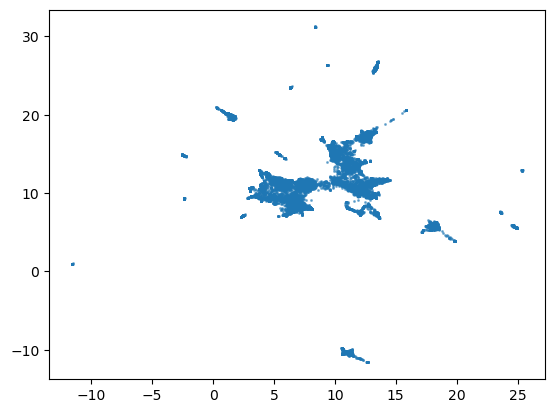

In [18]:
plt.scatter(embedding_cpu[:, 0], embedding_cpu[:, 1], marker='.', s=5, alpha=0.5)

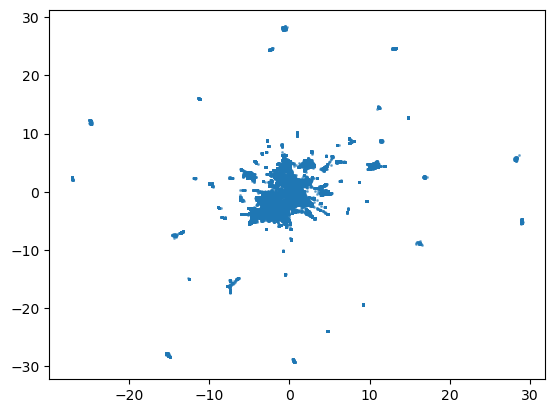

In [33]:
plt.scatter(embedding_gpu[:, 0], embedding_gpu[:, 1], marker='.', s=5, alpha=0.5)

In [ ]:
plt.scatter(embedding_gpu_precomp[:, 0], embedding_gpu_precomp[:, 1], marker='.', s=5, alpha=0.5)

The projection is very different! I can define some clusters on the CPU version, whereas there is mostly one globule in the GPU version.  
Using the `precomputed_knn` from the CPU version varies a bit the results, maybe better, but the GPU-based projection is still much more globular than the CPU-based version.  
subsampling by 50 takes 122s, which is 1.7h  

Can we fit on subset, and transform whole data?  
Can we use precomputed_knn for different number of dimensions? I should be able to, UMAP's nearest_neighbors doesn't have an `n_components` argument.  

#### try increasing n_epochs

In [20]:
len(var_aggreg.values[::subsamp, :])

56005

In [28]:
all_n_epochs = [200, 500, 1000, 2000, 5000, 10000]
n_conds = len(all_n_epochs)
durations = []
embeddings = np.zeros((n_conds, len(var_aggreg.values[::subsamp, :]), cluster_params['dim_clust']))

for i, n_epochs in enumerate(all_n_epochs):
    start = time()
    reducer_gpu = UMAP_gpu(
        random_state=None,
        n_components=cluster_params['dim_clust'],
        n_neighbors=cluster_params['n_neighbors'],
        metric=cluster_params['metric'],
        min_dist=cluster_params['min_dist'],
        n_epochs=n_epochs,
        )

    embeddings[i] = reducer_gpu.fit_transform(var_aggreg.values[::subsamp, :])
    durations.append(time() - start)

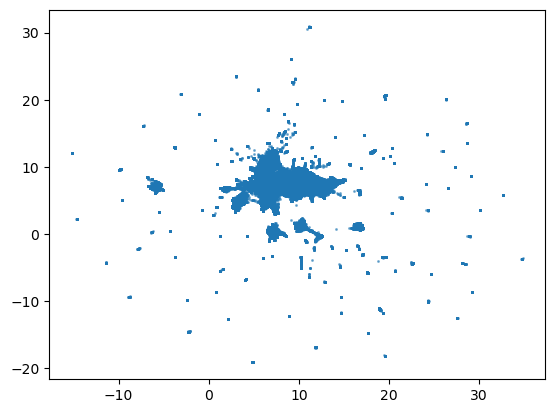

In [22]:
plt.scatter(embedding_cpu[:, 0], embedding_cpu[:, 1], marker='.', s=5, alpha=0.5)

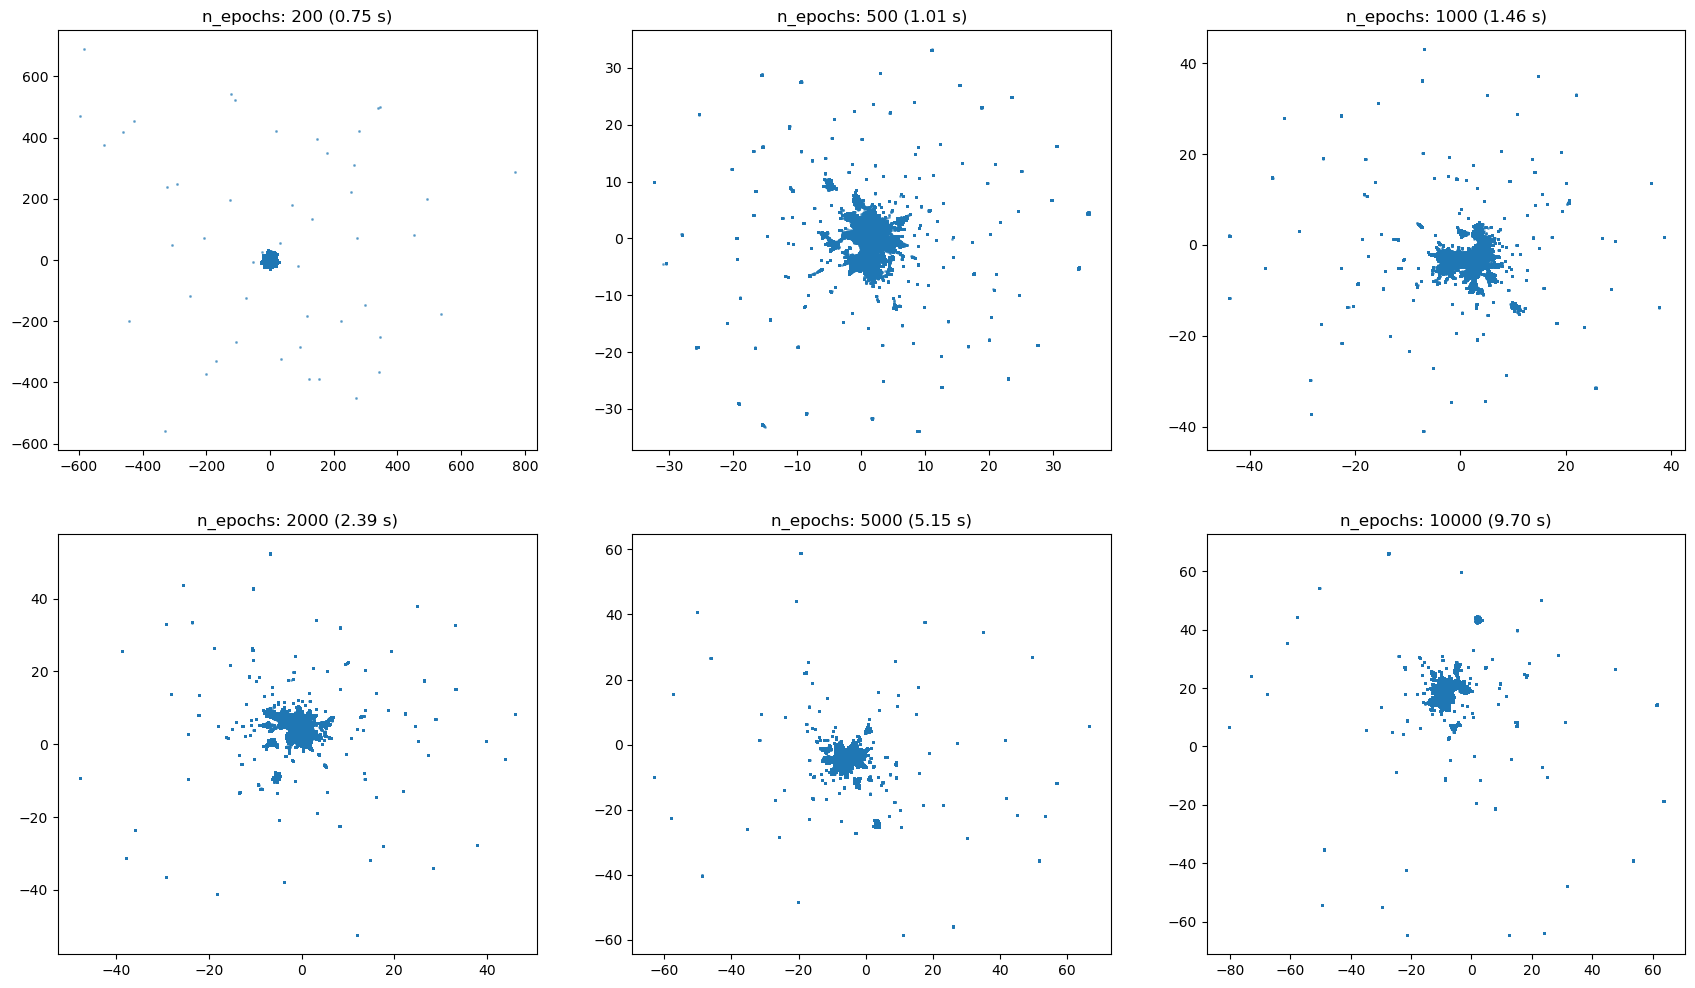

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(21, 12))
axs = axs.ravel()
for i, n_epochs in enumerate(all_n_epochs):
    axs[i].scatter(embeddings[i, :, 0], embeddings[i, :, 1], marker='.', s=5, alpha=0.5)
    axs[i].set_title(f'n_epochs: {n_epochs} ({durations[i]:.2f} s)')

In [32]:
# without subsampling

all_n_epochs = [200, 500, 1000, 2000, 5000, 10000]
n_conds = len(all_n_epochs)
durations = []
embeddings = np.zeros((n_conds, len(var_aggreg.values), cluster_params['dim_clust']))

for i, n_epochs in enumerate(all_n_epochs):
    start = time()
    reducer_gpu = UMAP_gpu(
        random_state=None,
        n_components=cluster_params['dim_clust'],
        n_neighbors=cluster_params['n_neighbors'],
        metric=cluster_params['metric'],
        min_dist=cluster_params['min_dist'],
        n_epochs=n_epochs,
        )

    embeddings[i] = reducer_gpu.fit_transform(var_aggreg.values)
    durations.append(time() - start)

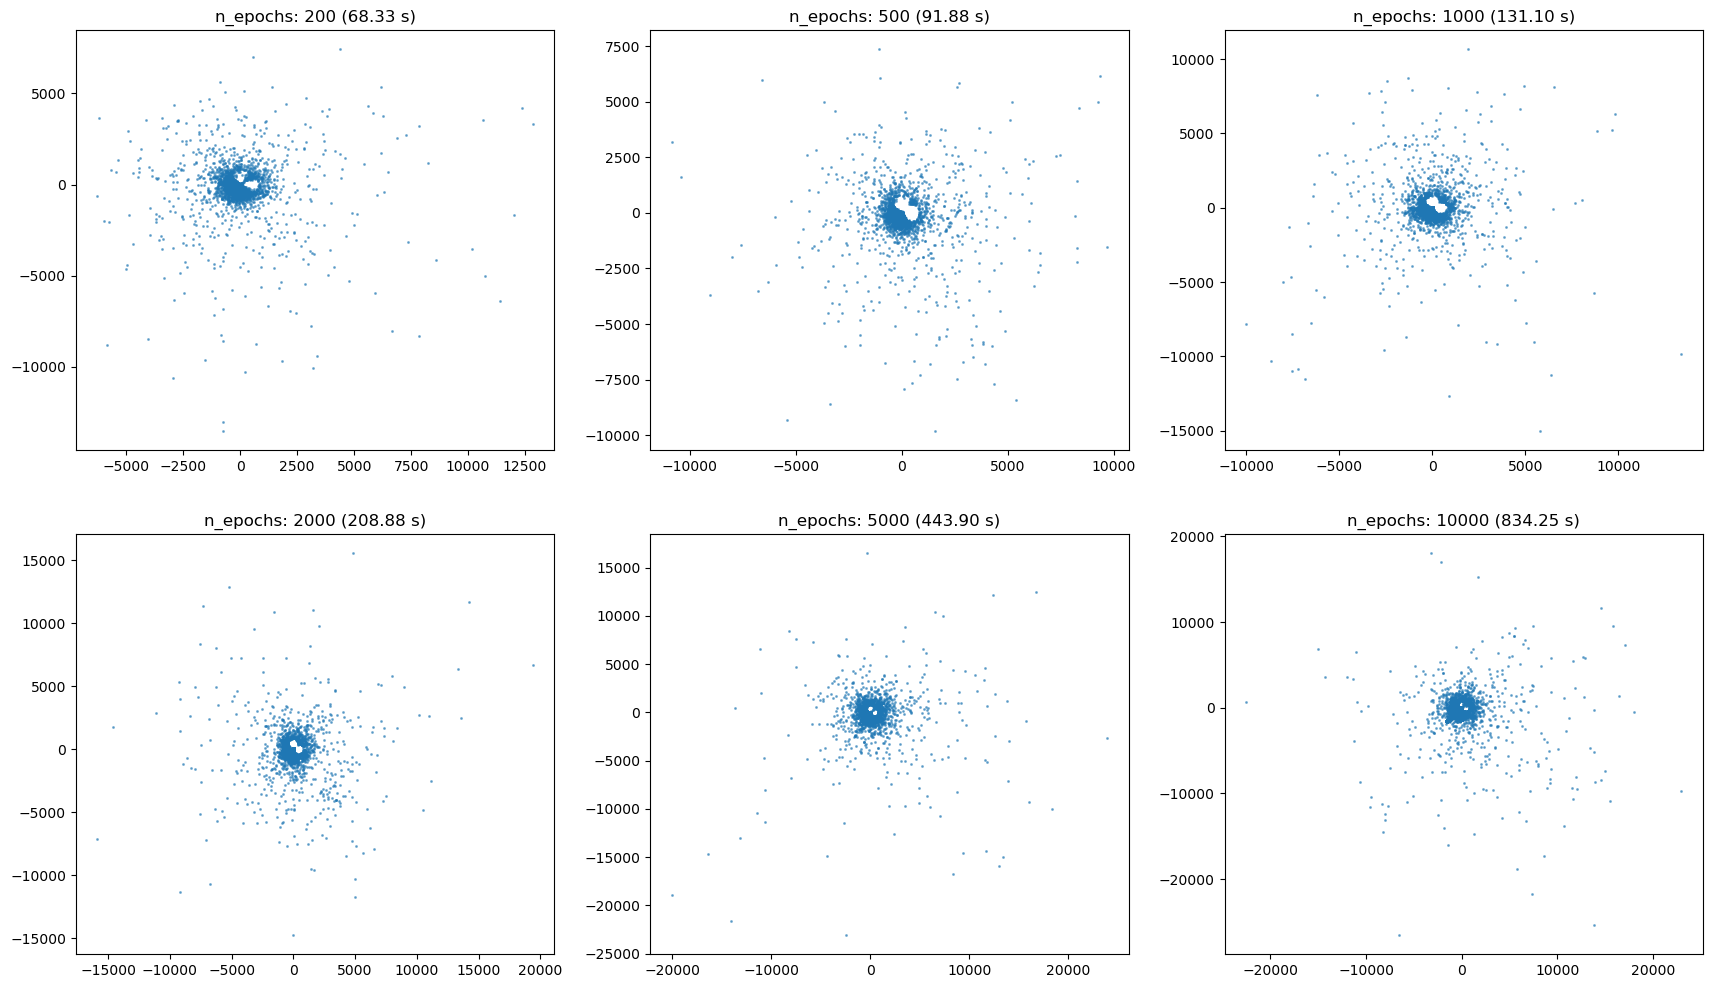

In [33]:
fig, axs = plt.subplots(2, 3, figsize=(21, 12))
axs = axs.ravel()
for i, n_epochs in enumerate(all_n_epochs):
    axs[i].scatter(embeddings[i, :, 0], embeddings[i, :, 1], marker='.', s=5, alpha=0.5)
    axs[i].set_title(f'n_epochs: {n_epochs} ({durations[i]:.2f} s)')

## Precompute for various n_components

In [ ]:
# precomputed_knn: tuple (optional, default (None,None,None))
#     If the k-nearest neighbors of each point has already been calculated you
#     can pass them in here to save computation time. The number of nearest
#     neighbors in the precomputed_knn must be greater or equal to the
#     n_neighbors parameter. This should be a tuple containing the output
#     of the nearest_neighbors() function or attributes from a previously fit
#     UMAP object; (knn_indices, knn_dists, knn_search_index). If you wish to use
#     k-nearest neighbors data calculated by another package then provide a tuple of
#     the form (knn_indices, knn_dists). The contents of the tuple should be two numpy
#     arrays of shape (N, n_neighbors) where N is the number of items in the
#     input data. The first array should be the integer indices of the nearest
#     neighbors, and the second array should be the corresponding distances. The
#     nearest neighbor of each item should be itself, e.g. the nearest neighbor of
#     item 0 should be 0, the nearest neighbor of item 1 is 1 and so on. Please note
#     that you will *not* be able to transform new data in this case.

In [31]:
k_subsample = 100
cluster_params['n_neighbors'] = 100
cluster_params['dim_clust'] = 3

In [32]:
start = time()
reducer_cpu = UMAP_cpu(
    random_state=None,
    n_components=cluster_params['dim_clust'],
    n_neighbors=cluster_params['n_neighbors'],
    metric=cluster_params['metric'],
    min_dist=cluster_params['min_dist'],
    )

embedding_cpu = reducer_cpu.fit_transform(var_aggreg.values[::k_subsample, :])
duration = time() - start
print(f'{duration:.2f} s')

53.67 s


In [33]:
start = time()
pre_computed_knn = nearest_neighbors(
    var_aggreg.values[::k_subsample, :],
    n_neighbors=cluster_params['n_neighbors'],
    metric=cluster_params['metric'],
    metric_kwds=None,
    angular=False,
    random_state=None,
    )
duration = time() - start
print(f'{duration:.2f} s')

10.32 s


In [37]:
start = time()
reducer_cpu_precomp = UMAP_cpu(
    random_state=None,
    n_components=cluster_params['dim_clust'],
    n_neighbors=cluster_params['n_neighbors'],
    metric=cluster_params['metric'],
    min_dist=cluster_params['min_dist'],
    precomputed_knn=pre_computed_knn,
    )

embedding_cpu_precomp = reducer_cpu_precomp.fit_transform(var_aggreg.values[::k_subsample, :])
duration = time() - start
print(f'{duration:.2f} s')

39.60 s


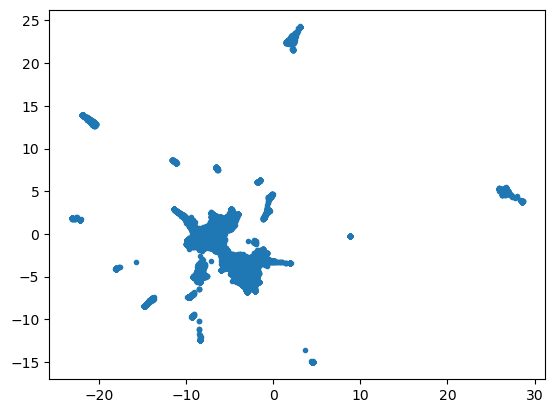

In [35]:
plt.scatter(embedding_cpu[:, 0], embedding_cpu[:, 1], marker='.', s=5, alpha=0.5)

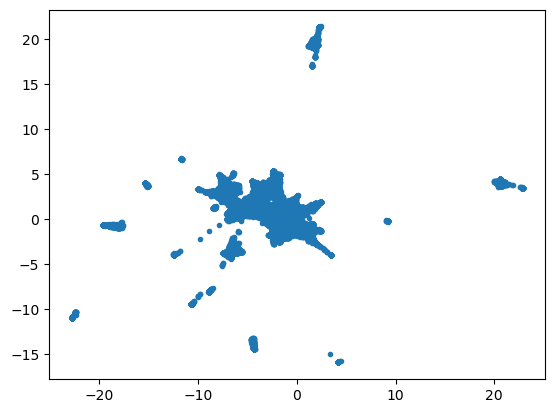

In [36]:
plt.scatter(embedding_cpu_precomp[:, 0], embedding_cpu_precomp[:, 1], marker='.', s=5, alpha=0.5)

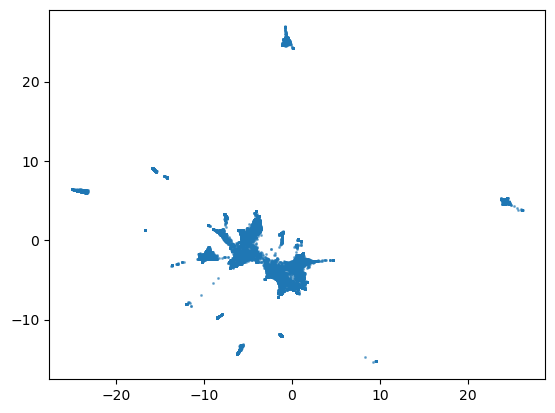

In [42]:
plt.scatter(embedding_cpu_precomp[:, 0], embedding_cpu_precomp[:, 1], marker='.', s=5, alpha=0.5)

## Train on subset, transform whole dataset

In [43]:
k_subsample = 100
k_subsub = 500
cluster_params['n_neighbors'] = 100
cluster_params['dim_clust'] = 2

In [44]:
start = time()
pre_computed_knn = nearest_neighbors(
    var_aggreg.values[::k_subsample, :],
    n_neighbors=cluster_params['n_neighbors'],
    metric=cluster_params['metric'],
    metric_kwds=None,
    angular=False,
    random_state=None,
    )
duration = time() - start
print(f'{duration:.2f} s')

10.14 s


In [46]:
start = time()
reducer_cpu = UMAP_cpu(
    random_state=None,
    n_components=cluster_params['dim_clust'],
    n_neighbors=cluster_params['n_neighbors'],
    metric=cluster_params['metric'],
    min_dist=cluster_params['min_dist'],
    precomputed_knn=pre_computed_knn,
    )

embedding_cpu = reducer_cpu.fit_transform(var_aggreg.values[::k_subsample, :])
duration = time() - start
print(f'{duration:.2f} s')

46.54 s


In [50]:
start = time()
reducer_cpu_subsamp = UMAP_cpu(
    random_state=None,
    n_components=cluster_params['dim_clust'],
    n_neighbors=cluster_params['n_neighbors'],
    metric=cluster_params['metric'],
    min_dist=cluster_params['min_dist'],
    precomputed_knn=pre_computed_knn,
    )

reducer = reducer_cpu_subsamp.fit(var_aggreg.values[::k_subsub, :])
duration = time() - start
print(f'{duration:.2f} s')

24.74 s


In [53]:
start = time()
embedding_cpu_subsamp = reducer_cpu_subsamp.transform(var_aggreg.values[::k_subsample, :])
duration = time() - start
print(f'{duration:.2f} s')

81.65 s


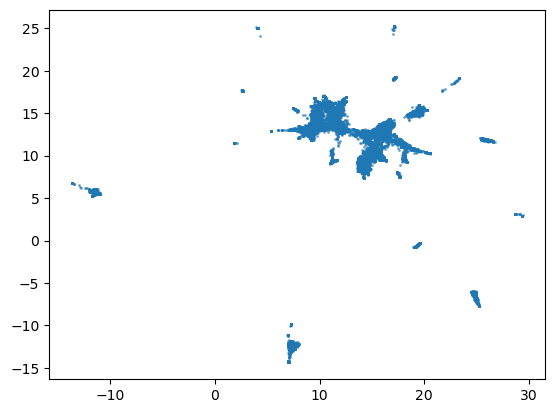

In [54]:
plt.scatter(embedding_cpu[:, 0], embedding_cpu[:, 1], marker='.', s=5, alpha=0.5)

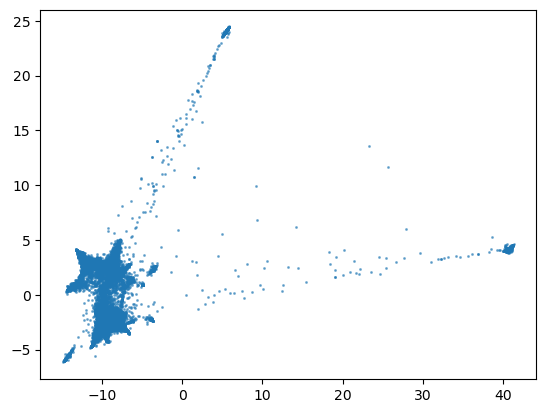

In [55]:
plt.scatter(embedding_cpu_subsamp[:, 0], embedding_cpu_subsamp[:, 1], marker='.', s=5, alpha=0.5)

This is pretty bad and it takes longer to compute. We will avoid that.

## Try clustering algorithms

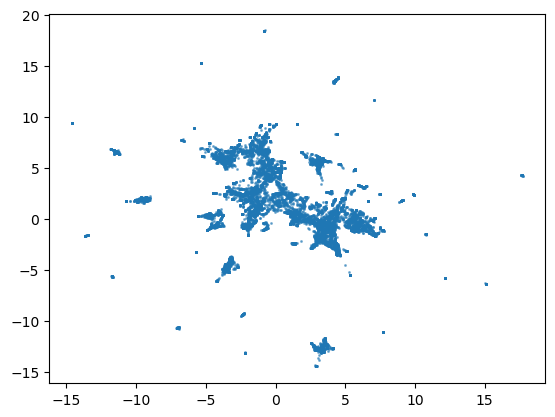

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1], marker='.', s=5, alpha=0.5)

In [99]:
import cupy as cp
import cugraph
import cudf
from cuml import UMAP
from cuml import HDBSCAN
from cuml.cluster.hdbscan import all_points_membership_vectors
from pycave.bayes import GaussianMixture
gpu_clustering = True

In [73]:
embedding_pairs = ty.build_knn(embedding, k=cluster_params['n_neighbors'])

In [74]:
edges_np = np.hstack((embedding_pairs, np.ones((len(embedding_pairs), 1)))).astype(np.int32)
edges = cudf.DataFrame(edges_np, columns=['src', 'dst', 'weight'])
G = cugraph.Graph()
G.from_cudf_edgelist(
    edges, 
    source='src', 
    destination='dst', 
    edge_attr='weight', 
    renumber=False,
    )

In [79]:
# leiden
partition, modularity_score = cugraph.leiden(G, max_iter=100, resolution=0.0005)
cluster_labels = partition['partition'].values
cluster_labels = mosna.to_numpy(cluster_labels)
print(len(np.unique(cluster_labels)))

38


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

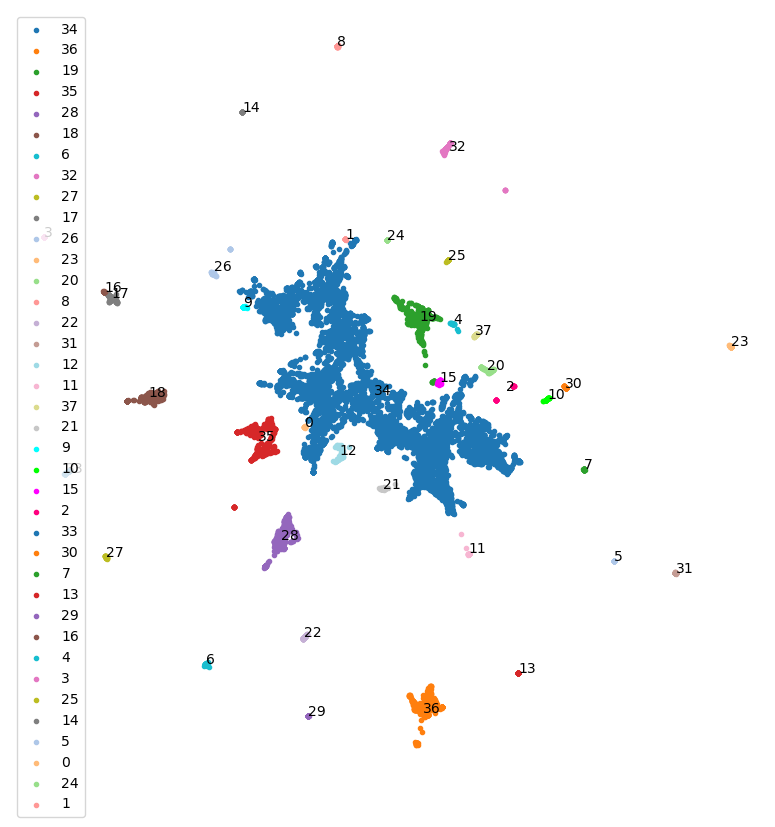

In [82]:
mosna.plot_clusters(embedding, cluster_labels)

In [86]:
# leiden
partition, modularity_score = cugraph.leiden(G, max_iter=100, resolution=0.05)
cluster_labels = partition['partition'].values
cluster_labels = mosna.to_numpy(cluster_labels)
print(len(np.unique(cluster_labels)))

45


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

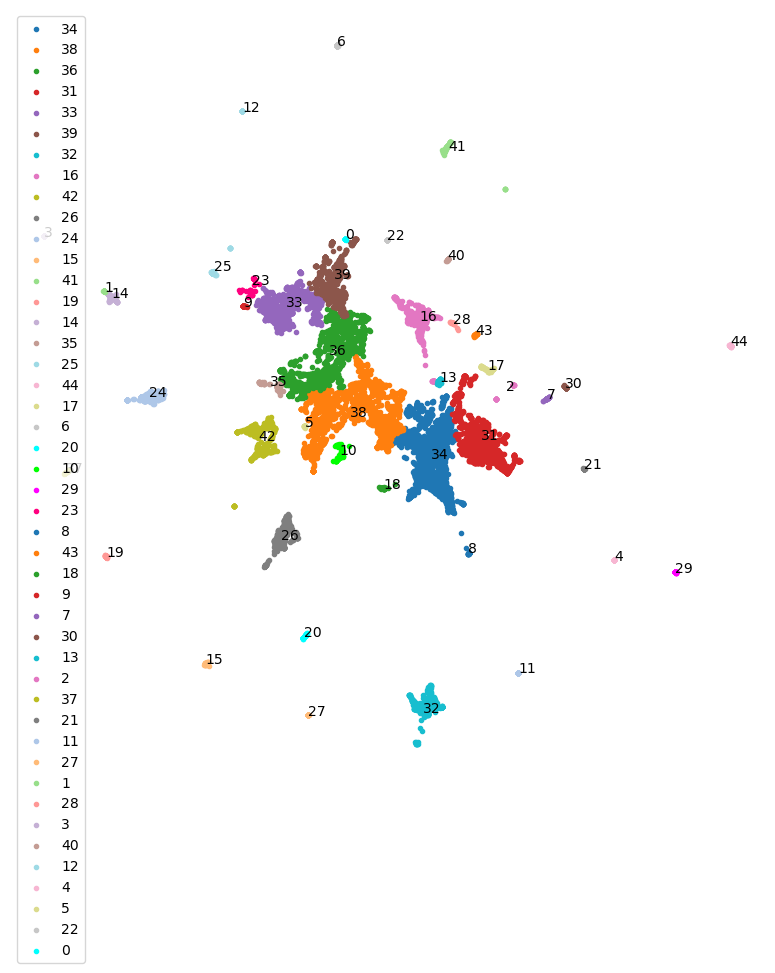

In [87]:
mosna.plot_clusters(embedding, cluster_labels)

In [84]:
# ECG
partition = cugraph.ecg(G, min_weight=0.05, ensemble_size=20)
cluster_labels = partition['partition'].values
cluster_labels = mosna.to_numpy(cluster_labels)
print(len(np.unique(cluster_labels)))

170


In [ ]:
mosna.plot_clusters(embedding, cluster_labels)

In [89]:
# spectral
partition = cugraph.spectralBalancedCutClustering(G, 20)
cluster_labels = partition['cluster'].values
cluster_labels = mosna.to_numpy(cluster_labels)
print(len(np.unique(cluster_labels)))

20


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

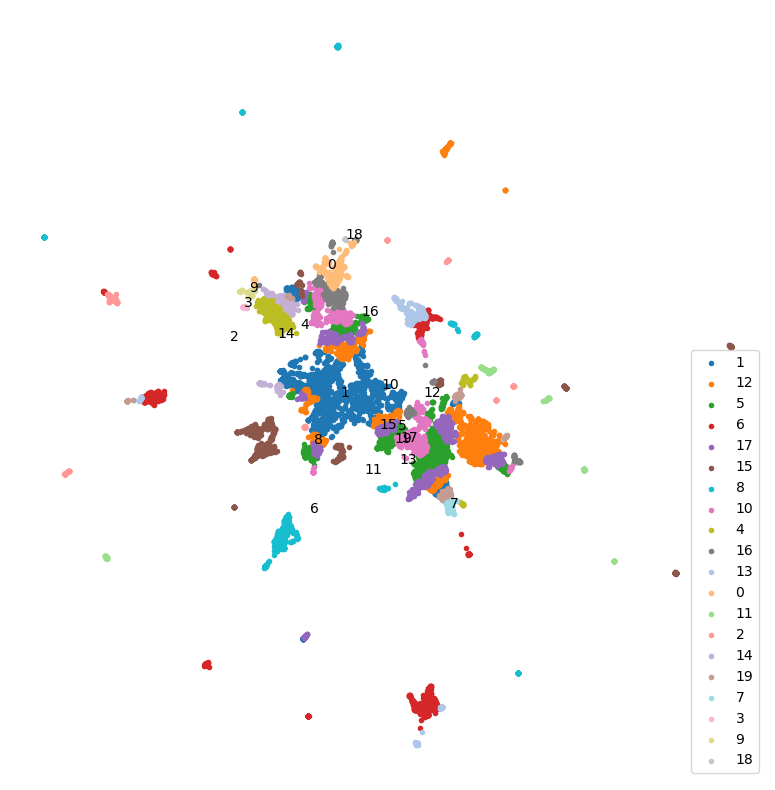

In [90]:
mosna.plot_clusters(embedding, cluster_labels)

In [95]:
# HDBSCAN
clusterer = HDBSCAN( 
    min_cluster_size=50, 
    min_samples=1,
)
clusterer.fit(embedding)
cluster_labels = clusterer.labels_
cluster_labels = mosna.to_numpy(cluster_labels)
print(len(np.unique(cluster_labels)))

65


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

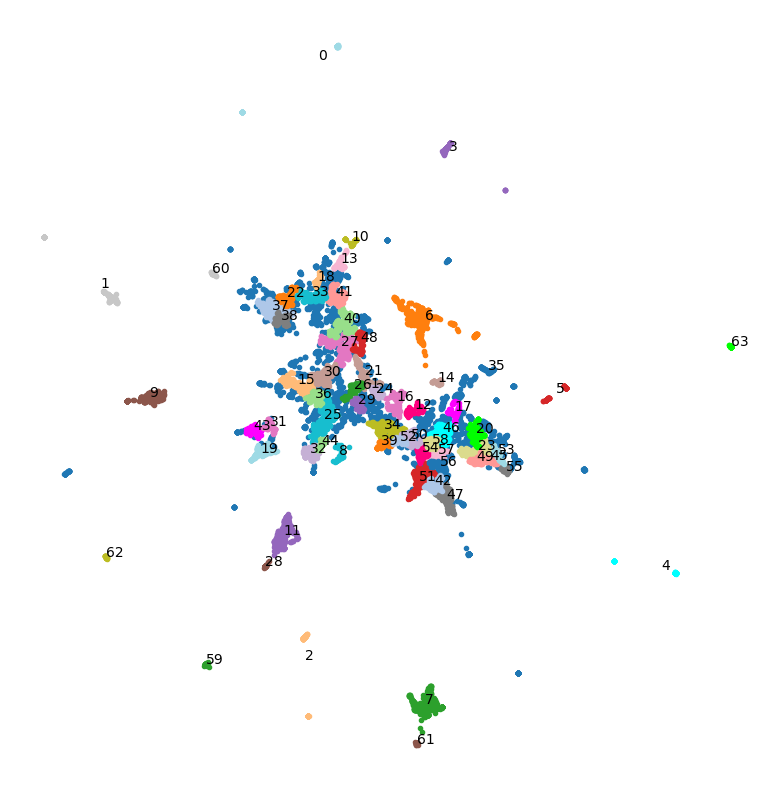

In [97]:
mosna.plot_clusters(embedding, cluster_labels, legend=False)

In [ ]:
# GMM
clusterer = GaussianMixture(20, trainer_params=dict(accelerator='gpu', devices=1))
# make cluster predictions
clusterer.fit(embedding.astype(np.float32))
cluster_labels = np.array(clusterer.predict(embedding.astype(np.float32)))
cluster_labels = mosna.to_numpy(cluster_labels)
print(len(np.unique(cluster_labels)))

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

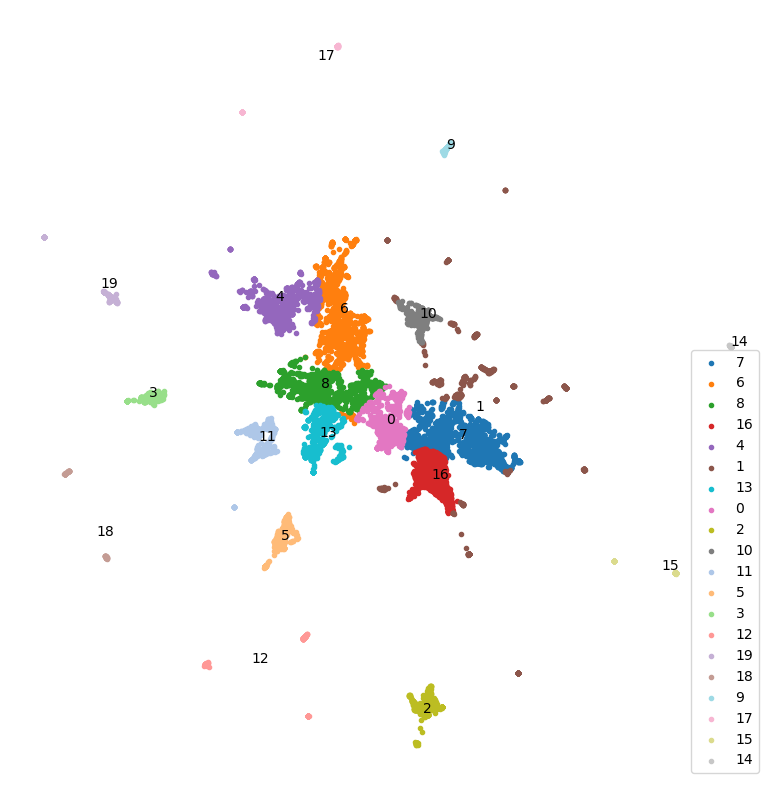

In [104]:
mosna.plot_clusters(embedding, cluster_labels)

In [103]:
embedding.shape

(11201, 2)

In [107]:
start = time()
reducer_cpu = UMAP_cpu(
    random_state=None,
    n_components=200,
    n_neighbors=cluster_params['n_neighbors'],
    metric=cluster_params['metric'],
    min_dist=cluster_params['min_dist'],
    # precomputed_knn=pre_computed_knn,
    )

embedding_cpu = reducer_cpu.fit_transform(var_aggreg.values[::k_subsample, :])
duration = time() - start
print(f'{duration:.2f} s')

36.10 s


In [108]:
36*100/3600

1.0